In [3]:
!pip install -q imdb-sqlite


In [4]:
!pip install -q pycountry

In [5]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [7]:
# Fazendo a conexão à base de dados e abrindo o cursor

conn = sqlite3.connect("imdb.db")
c = conn.cursor()

# <font color='blue'>1- Quais as categorias de filmes mais comuns no IMdB?</font> 

In [19]:
# Usando SQL para selecionar as categorias e suas quantidades na tabela de titulos 
verifica1 = pd.read_sql_query('''
                              SELECT type AS Categorias, COUNT (*) AS Quantidades FROM titles GROUP BY type
                              ''', conn)
verifica1

,Categorias,Quantidades
0,movie,597227
1,short,847536
2,tvEpisode,6371641
3,tvMiniSeries,41226
4,tvMovie,134148
5,tvPilot,2
6,tvSeries,218261
7,tvShort,10422
8,tvSpecial,35334
9,video,255872


In [18]:
# Criando a coluna de percentuais e ordenando o DataFrame
verifica1['Percentuais (%)']=((verifica1['Quantidades'])/verifica1['Quantidades'].sum())*100
df1 = verifica1.sort_values(by=['Percentuais (%)'], ascending=False)
df1 = df1.reset_index(drop=True)
df1

,Categorias,Quantidades,Percentuais (%)
0,tvEpisode,6371641,74.594976
1,short,847536,9.922393
2,movie,597227,6.991940
3,video,255872,2.995581
4,tvSeries,218261,2.555256
5,tvMovie,134148,1.570516
6,tvMiniSeries,41226,0.482647
7,tvSpecial,35334,0.413667
8,videoGame,29980,0.350986
9,tvShort,10422,0.122014


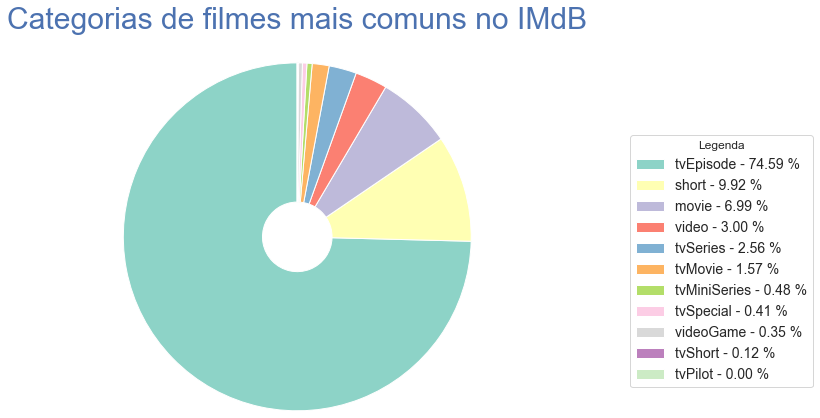

In [21]:
# Montando o gráfico
cs = cm.Set3(np.arange(100))

x = np.array(df1['Categorias'])
y = np.array(df1['Percentuais (%)'])


patches, texts = plt.pie(y, startangle=90, radius=2, wedgeprops=dict(width=1.6), colors=cs)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, y)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='best', bbox_to_anchor=(2, 1.),
           fontsize=14, title='Legenda')
plt.title('Categorias de filmes mais comuns no IMdB', pad=99, fontdict = {'fontsize':30,'fontweight':20}, color='b')

plt.show()


# <font color='blue'>2- Qual o número de títulos por gênero?</font> 

In [44]:
# Varifica os nomes únicos das categorias
verifica2 = pd.read_sql_query ('''
                                SELECT genres
                                FROM titles
                                WHERE type == 'movie'
                                ''', conn)


# # Converter strings para minusculo
verifica2['genres'] = verifica2['genres'].str.lower()
verifica2

# # # Remove valores NA
filmes_temp = verifica2['genres'].dropna()
filmes_temp


0                                 \n
1         action,adventure,biography
2                              drama
3                              drama
4                              drama
                     ...            
597222                   documentary
597223                   documentary
597224                        comedy
597225                            \n
597226                   documentary
Name: genres, Length: 597227, dtype: object

In [45]:
# Criar um vetor usando expressão regular para filtrar strings

padrao = '(?u)\\b[\\w-]+\\b'

vetor = CountVectorizer(token_pattern=padrao, analyzer='word').fit(filmes_temp)

# Aplica a vetorização ao dataset sem NA
bag_generos = vetor.transform(filmes_temp)
bag_generos


<597227x29 sparse matrix of type '<class 'numpy.int64'>'
	with 875460 stored elements in Compressed Sparse Row format>

In [46]:
gen_unicos = vetor.get_feature_names()
gen_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'n',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [47]:
# Cria df de generos
generos = pd.DataFrame(bag_generos.todense(), columns=gen_unicos, index=filmes_temp.index)
# generos

# Drop coluna n
generos2=generos.drop(columns='n', axis=0)
generos2

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597222,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
597223,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
597224,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Calcula o número de filmes por gênero
generos_qtd=generos2.sum().sort_values(ascending=False)
generos_qtd


drama          214423
documentary    110377
comedy         101438
action          50011
romance         43928
thriller        40292
crime           34179
horror          32890
adventure       26108
family          16524
biography       15706
mystery         15408
fantasy         13986
history         13085
sci-fi          12725
music           11035
musical          9747
war              8900
adult            8364
animation        7988
western          7948
sport            6355
news             1431
film-noir         764
reality-tv        444
talk-show         137
short              59
game-show          19
dtype: int64

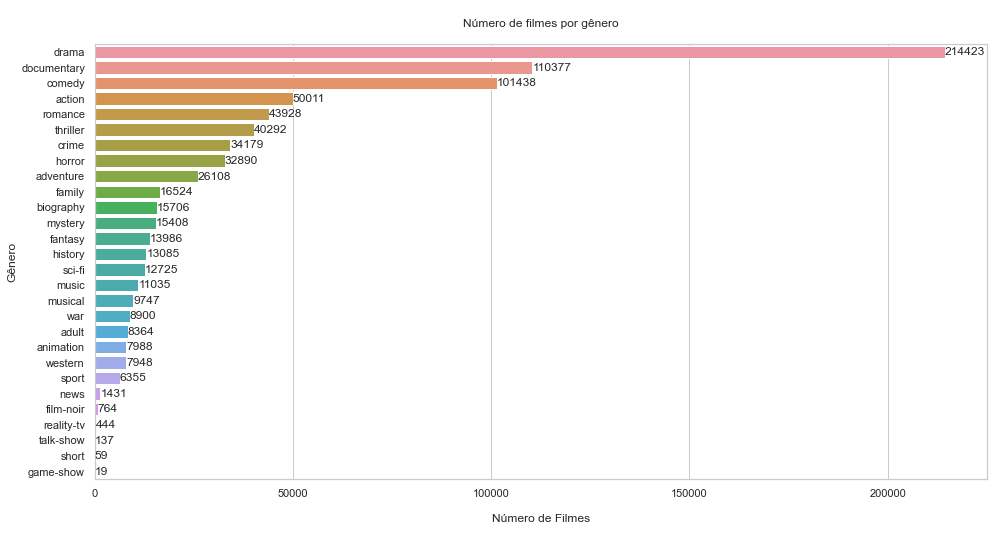

In [57]:
# Plot
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.25)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


plt.figure(figsize=(16,8))
ax = sns.barplot(x = generos_qtd, y = generos_qtd.index)
plt.ylabel("Gênero")
plt.xlabel("\nNúmero de Filmes\n")
plt.title("\nNúmero de filmes por gênero\n")
show_values(ax, "h", space=0.2)

plt.show()


# <font color='blue'>3- Qual a mediana de avaliação dos filmes por gênero?</font> 

In [61]:
verifica3 = pd.read_sql_query('''
                               SELECT 
                               A. genres,
                               B. rating
                               FROM titles AS A LEFT JOIN ratings AS B ON A.title_id=B.title_id
                               WHERE type='movie'
                              ''', conn)
verifica3

,genres,rating
0,\N,4.5
1,"Action,Adventure,Biography",6.1
2,Drama,5.2
3,Drama,4.5
4,Drama,3.8
...,...,...
597222,Documentary,NaN
597223,Documentary,NaN
597224,Comedy,NaN
597225,\N,NaN


In [62]:
# função para retornar os gêneros, igual foi feito no 2
def retorna_generos(df):
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    # esse aqui debaixo eh só pra tirar o gênero 'n' que aparece no feature_names
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [63]:
generos_unicos = retorna_generos(verifica3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [117]:
conta_filmes =[]
cont = 0
for item in generos_unicos:
    # contar a qtd de filmes existente para cada item da lista generos_unicos
    # Isso é importante para que se compare melhor as medianas. Pois, pode-se ter
    # medianas com valor muito alto, mas que levaram em consideração poucos filmes.
    # Ao passo que pode haver medianas baixas justamente porque levaram em consideração muitos filmes.
    count_genres = pd.read_sql_query(f'''
                                SELECT count(*) AS qtd_filmes
                                FROM titles 
                                WHERE type='movie' AND (genres LIKE '%,{item},%' OR
                                genres LIKE '{item}' OR genres LIKE '%,{item}' OR genres LIKE '{item},%') 
                                ''', conn)
# o que foi feito acima com os LIKE e OR é explicado na resolução da questão 7.
    conta_filmes.append(count_genres['qtd_filmes'].values[0])
    
conta_filmes

[50011,
 8364,
 26108,
 7988,
 15706,
 101438,
 34179,
 110377,
 214423,
 16524,
 13986,
 764,
 19,
 13085,
 32890,
 11035,
 9747,
 15408,
 1431,
 444,
 43928,
 12725,
 59,
 6355,
 137,
 40292,
 8900,
 7948]

In [116]:
# Apuração das medianas de cada gênero
conta_medianas =[]
for item in generos_unicos:
    count_med = pd.read_sql_query(f'''
                                SELECT 
                                B.rating as median_rating
                                FROM titles as A LEFT JOIN  ratings as B on A.title_id=B.title_id
                                WHERE type='movie' AND (genres LIKE '%,{item},%' OR
                                genres LIKE '{item}' OR genres LIKE '%,{item}' OR genres LIKE '{item},%') 
                                ''', conn)
    semna = count_med.dropna(subset=['median_rating'])
    mediana = np.median(semna['median_rating'])
    conta_medianas.append(mediana)
conta_medianas


[5.8,
 5.8,
 6.0,
 6.4,
 7.0,
 6.0,
 6.1,
 7.3,
 6.3,
 6.3,
 6.1,
 6.6,
 6.800000000000001,
 6.9,
 5.0,
 6.9,
 6.3,
 6.0,
 7.3,
 6.1,
 6.2,
 5.4,
 7.2,
 6.7,
 6.9,
 5.6,
 6.6,
 6.1]

In [118]:
df3 = pd.DataFrame(generos_unicos, columns=['Gêneros'])
df3['Quantidade de Filmes'] = conta_filmes
df3['Medianas das Notas'] = conta_medianas
# aqui vou primeiro fazer a limpa dos NAN, depois colocar em ordem descrescente de medianas e por ultimo resetar o indice
resultado3 = df3.dropna().sort_values(by=['Medianas das Notas'], ascending=False).reset_index(drop=True)
resultado3

,Gêneros,Quantidade de Filmes,Medianas das Notas
0,news,1431,7.3
1,documentary,110377,7.3
2,short,59,7.2
3,biography,15706,7.0
4,talk-show,137,6.9
5,music,11035,6.9
6,history,13085,6.9
7,game-show,19,6.8
8,sport,6355,6.7
9,war,8900,6.6


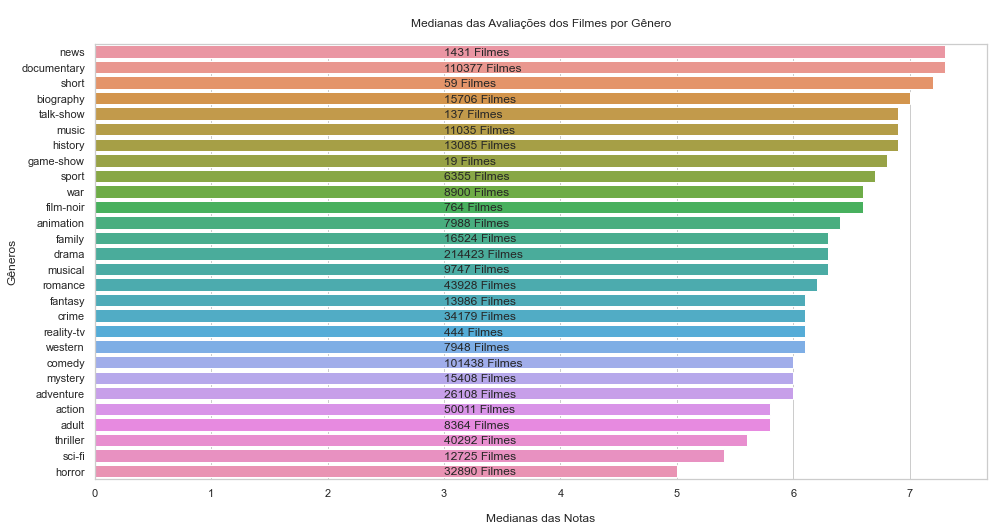

In [119]:
plt.figure(figsize = (16,8))
sns.barplot(x = resultado3['Medianas das Notas'], y = resultado3['Gêneros'], orient = "h")
plt.ylabel('Gêneros')             
plt.xlabel("\nMedianas das Notas")
plt.title('\nMedianas das Avaliações dos Filmes por Gênero\n')


for i in range(len(resultado3)):
    plt.text(3.0, i + 0.25, str(resultado3['Quantidade de Filmes'][resultado3.index[i]]) +' Filmes', fontsize=12)

plt.show()

# <font color='blue'>4- Qual a mediana de avaliação dos filmes em relação ao ano de estréia?</font> 

In [69]:
verifica4 = pd.read_sql_query('''
                               SELECT 
                               A. premiered,
                               B. rating
                               FROM titles AS A LEFT JOIN ratings AS B ON A.title_id=B.title_id
                               WHERE type='movie' AND premiered <= 2022
                               ORDER BY premiered
                              ''', conn)
verifica4 = verifica4.dropna().reset_index(drop=True)
verifica4

,premiered,rating
0,1896,6.4
1,1897,4.5
2,1899,3.9
3,1899,3.7
4,1900,6.0
...,...,...
272496,2021,5.9
272497,2021,5.4
272498,2021,6.6
272499,2021,6.0


In [98]:
df_year = pd.DataFrame(verifica4['premiered'], columns=['premiered'])
df_year = df_year['premiered'].unique().tolist()
df_year

[1896,
 1897,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [77]:
conta_medianas =[]
for year in df_year:
    count_med = pd.read_sql_query(f'''
                                SELECT 
                                B.rating as median_rating
                                FROM titles as A LEFT JOIN  ratings as B on A.title_id=B.title_id
                                WHERE A.type='movie' and A.premiered like '{year}' 
                                ''', conn)
    semna = count_med.dropna(subset=['median_rating'])
    mediana = np.median(semna['median_rating'])
    conta_medianas.append(mediana)
conta_medianas

[6.4,
 4.5,
 3.8,
 5.85,
 4.6,
 3.5,
 4.6,
 5.4,
 4.5,
 3.6,
 4.4,
 5.3,
 5.1,
 5.0,
 4.65,
 5.5,
 5.7,
 6.05,
 6.2,
 6.2,
 6.2,
 6.0,
 6.15,
 5.8,
 6.2,
 6.2,
 6.3,
 6.4,
 6.3,
 6.4,
 6.5,
 6.6,
 6.4,
 6.1,
 6.0,
 6.2,
 6.3,
 6.3,
 6.2,
 6.2,
 6.2,
 6.2,
 6.3,
 6.3,
 6.3,
 6.2,
 6.3,
 6.2,
 6.2,
 6.4,
 6.4,
 6.4,
 6.4,
 6.3,
 6.3,
 6.3,
 6.2,
 6.2,
 6.3,
 6.2,
 6.3,
 6.3,
 6.3,
 6.4,
 6.3,
 6.3,
 6.3,
 6.3,
 6.2,
 6.2,
 6.2,
 6.2,
 6.1,
 6.1,
 6.0,
 6.0,
 6.0,
 6.1,
 6.0,
 6.1,
 6.1,
 6.2,
 6.2,
 6.1,
 6.2,
 6.1,
 6.1,
 6.15,
 6.2,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 6.0,
 6.2,
 6.2,
 6.2,
 6.1,
 6.2,
 6.3,
 6.4,
 6.3,
 6.4,
 6.4,
 6.3,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 6.3,
 6.3,
 6.4,
 6.6]

In [78]:
df4 = pd.DataFrame(df_year, columns=['Ano de Estréia'])
df4['Medianas das Notas'] = conta_medianas
df4


,Ano de Estréia,Medianas das Notas
0,1896,6.40
1,1897,4.50
2,1899,3.80
3,1900,5.85
4,1901,4.60
...,...,...
120,2017,6.40
121,2018,6.30
122,2019,6.30
123,2020,6.40


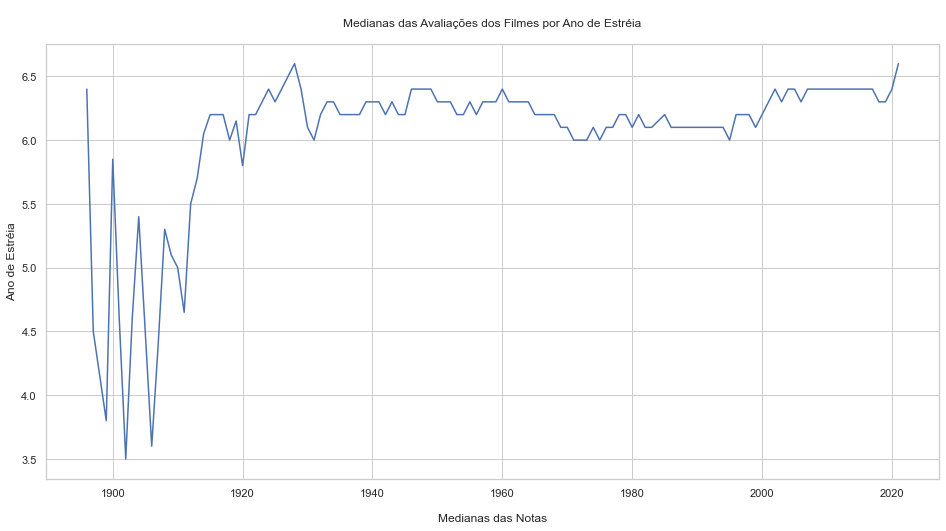

In [81]:
plt.figure(figsize = (16,8))
plt.plot(df4['Ano de Estréia'], df4['Medianas das Notas'])
plt.ylabel('Ano de Estréia')             
plt.xlabel("\nMedianas das Notas")
plt.title('\nMedianas das Avaliações dos Filmes por Ano de Estréia\n')

plt.show()

# <font color='blue'>5- Qual o número de filmes avaliados por gênero em relação ao ano de estréia?</font> 

In [83]:
verifica5 = pd.read_sql_query('''
                               SELECT genres AS generos
                               FROM titles
                               WHERE type='movie' AND premiered != 'NaN' AND generos != '\\N' AND premiered <= 2022
                               ''', conn)
verifica5 = verifica5['generos'].dropna()
verifica5 = pd.DataFrame(verifica5)
verifica5 = verifica5.sort_values(by=['generos'], ascending=False).reset_index(drop=True)
verifica5['generos'] = verifica5['generos'].str.lower()
# usei o primeiro reset_index pra poder deletar aqueles /N, pois precisava saber quais eram os indices
# ja nesse segundo reset_index, eu usei so pra deixar organizado
verifica5 = verifica5.reset_index(drop=True)
# tive que botar nesse formato abaixo, pois o countvectorizer.fit() só aceita nesse formato de Séries, 
# e nao no de data frame
verifica5 = verifica5['generos']
verifica5

0         western
1         western
2         western
3         western
4         western
           ...   
452569     action
452570     action
452571     action
452572     action
452573     action
Name: generos, Length: 452574, dtype: object

In [84]:
vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(verifica5)

In [85]:
generos_unicos = vetor.get_feature_names()
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [87]:
bag_generos = vetor.transform(verifica5)

In [88]:
print(bag_generos)

  (0, 27)	1
  (1, 27)	1
  (2, 27)	1
  (3, 27)	1
  (4, 27)	1
  (5, 27)	1
  (6, 27)	1
  (7, 27)	1
  (8, 27)	1
  (9, 27)	1
  (10, 27)	1
  (11, 27)	1
  (12, 27)	1
  (13, 27)	1
  (14, 27)	1
  (15, 27)	1
  (16, 27)	1
  (17, 27)	1
  (18, 27)	1
  (19, 27)	1
  (20, 27)	1
  (21, 27)	1
  (22, 27)	1
  (23, 27)	1
  (24, 27)	1
  :	:
  (452549, 0)	1
  (452550, 0)	1
  (452551, 0)	1
  (452552, 0)	1
  (452553, 0)	1
  (452554, 0)	1
  (452555, 0)	1
  (452556, 0)	1
  (452557, 0)	1
  (452558, 0)	1
  (452559, 0)	1
  (452560, 0)	1
  (452561, 0)	1
  (452562, 0)	1
  (452563, 0)	1
  (452564, 0)	1
  (452565, 0)	1
  (452566, 0)	1
  (452567, 0)	1
  (452568, 0)	1
  (452569, 0)	1
  (452570, 0)	1
  (452571, 0)	1
  (452572, 0)	1
  (452573, 0)	1


In [89]:
count_filmes = pd.DataFrame(bag_generos.todense(), columns = generos_unicos)
display(count_filmes)

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452569,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452570,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452571,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452572,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
count_filmes = pd.Series(count_filmes.sum())
count_filmes

action          40978
adult            8248
adventure       22135
animation        6641
biography       13394
comedy          90174
crime           30370
documentary    103931
drama          189548
family          14861
fantasy         11230
film-noir         764
game-show          14
history         11719
horror          24733
music           10395
musical          9131
mystery         13463
news             1368
reality-tv        410
romance         40653
sci-fi           8428
short              54
sport            5698
talk-show         125
thriller        29357
war              8133
western          7242
dtype: int64

In [91]:
count_filmes = count_filmes.values.tolist()
count_filmes


[40978,
 8248,
 22135,
 6641,
 13394,
 90174,
 30370,
 103931,
 189548,
 14861,
 11230,
 764,
 14,
 11719,
 24733,
 10395,
 9131,
 13463,
 1368,
 410,
 40653,
 8428,
 54,
 5698,
 125,
 29357,
 8133,
 7242]

In [102]:
df5 = pd.DataFrame()
df5['Gêneros'] = generos_unicos
df5['QTD Filmes'] = count_filmes
df5 = df5.sort_values(by=['QTD Filmes'], ascending = False).reset_index(drop=True)
df5 = df5.head()
df5

,Gêneros,QTD Filmes
0,drama,189548
1,documentary,103931
2,comedy,90174
3,action,40978
4,romance,40653


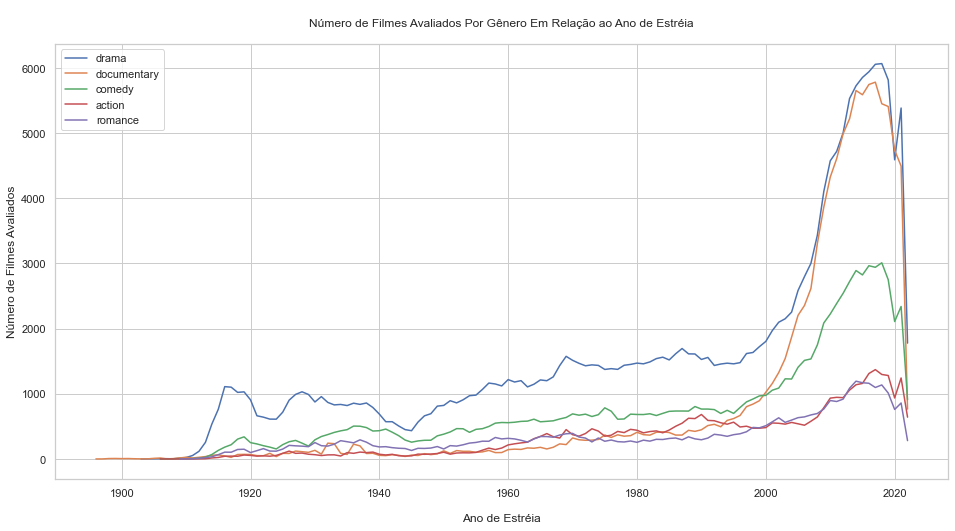

In [107]:
# conta_medianas =[]
plt.figure(figsize = (16,8))

for genero in df5['Gêneros']:
    consulta5 = pd.read_sql_query(f'''
                                SELECT 
                                premiered AS ano_estreia, genres AS generos, COUNT(*) AS qtd_filmes
                                FROM titles
                                WHERE type='movie' AND generos LIKE '%{genero}%' AND ano_estreia != 'NaN' AND ano_estreia <=2022
                                GROUP BY ano_estreia
                                ''', conn)
    plt.plot(consulta5['ano_estreia'], consulta5['qtd_filmes'])

plt.xlabel('\nAno de Estréia')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = df5['Gêneros'])
plt.show()

# <font color='blue'>6- Qual o filme com maior tempo de duração? Calcule os percentis.</font> 

In [108]:
verifica6 = pd.read_sql_query('''
                                SELECT runtime_minutes AS tempo_duracao, original_title AS titulo
                                FROM titles
                                WHERE type='movie' AND tempo_duracao != 'NULL'
                                ''', conn)
verifica6

,tempo_duracao,titulo
0,100,Bohemios
1,70,The Story of the Kelly Gang
2,90,L'enfant prodigue
3,120,The Fairylogue and Radio-Plays
4,58,Don Juan de Serrallonga
...,...,...
375469,123,Kuambil Lagi Hatiku
375470,57,Rodolpho Teóphilo - O Legado de um Pioneiro
375471,100,De la ilusión al desconcierto: cine colombiano...
375472,116,6 Gunn


In [109]:
verifica6 = verifica6.sort_values(by=['tempo_duracao'], ascending=False).reset_index(drop=True)
verifica6.head(1)

,tempo_duracao,titulo
0,51420,Logistics


In [110]:
for i in range(0,101):
    ordinal = i
    percentil = np.percentile(verifica6['tempo_duracao'], ordinal)
    print('O {}º percentil do Tempo de Duração dos filmes é: {}'.format(ordinal,percentil))

O 0º percentil do Tempo de Duração dos filmes é: 1.0
O 1º percentil do Tempo de Duração dos filmes é: 45.0
O 2º percentil do Tempo de Duração dos filmes é: 48.0
O 3º percentil do Tempo de Duração dos filmes é: 50.0
O 4º percentil do Tempo de Duração dos filmes é: 50.0
O 5º percentil do Tempo de Duração dos filmes é: 52.0
O 6º percentil do Tempo de Duração dos filmes é: 52.0
O 7º percentil do Tempo de Duração dos filmes é: 54.0
O 8º percentil do Tempo de Duração dos filmes é: 55.0
O 9º percentil do Tempo de Duração dos filmes é: 56.0
O 10º percentil do Tempo de Duração dos filmes é: 58.0
O 11º percentil do Tempo de Duração dos filmes é: 59.0
O 12º percentil do Tempo de Duração dos filmes é: 60.0
O 13º percentil do Tempo de Duração dos filmes é: 60.0
O 14º percentil do Tempo de Duração dos filmes é: 60.0
O 15º percentil do Tempo de Duração dos filmes é: 62.0
O 16º percentil do Tempo de Duração dos filmes é: 63.0
O 17º percentil do Tempo de Duração dos filmes é: 65.0
O 18º percentil do Te

# <font color='blue'>7- Qual a relação entre duração e gênero?</font> 

In [111]:
verifica7 = pd.read_sql_query('''
                                SELECT genres AS generos
                                FROM titles
                                WHERE type='movie' AND generos != '\\N' AND runtime_minutes != 'NULL'
                                ''',conn)
# esse squeeze é para transformar o dataframe (verifica7) em series, pois o countvectorizer.fit() nao faz pra dataframe
verifica7 = verifica7.squeeze()
verifica7

0         Action,Adventure,Biography
1                              Drama
2                  Adventure,Fantasy
3                    Adventure,Drama
4                              Drama
                     ...            
352043                 Drama,History
352044                         Drama
352045                   Documentary
352046                   Documentary
352047                   Documentary
Name: generos, Length: 352048, dtype: object

In [112]:
vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(verifica7)
generos_unicos = vetor.get_feature_names()
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [113]:
conta_medianas = []
for genero in generos_unicos:
    resposta7 = pd.read_sql_query(f'''
                                SELECT runtime_minutes AS tempo_duracao 
                                FROM titles
                                WHERE type='movie' AND tempo_duracao != 'NULL' AND (genres LIKE '%,{genero},%' OR
                                genres LIKE '{genero}' OR genres LIKE '%,{genero}' OR genres LIKE '{genero},%')
                                ''',conn)
# Há uma nota explicativa sobre a parte dos LIKE e OR
    mediana = np.median(resposta7['tempo_duracao'])
    conta_medianas.append(mediana)
conta_medianas

[94.0,
 77.0,
 90.0,
 81.0,
 87.0,
 91.0,
 92.0,
 74.0,
 93.0,
 89.0,
 90.0,
 83.0,
 55.0,
 90.0,
 88.0,
 87.0,
 93.0,
 91.0,
 75.0,
 90.0,
 95.0,
 90.0,
 19.0,
 90.0,
 78.5,
 92.0,
 93.0,
 72.0]

In [114]:
df7 = pd.DataFrame()
df7['Gêneros'] = generos_unicos
df7['Medianas da Duração dos Filmes'] = conta_medianas
df7 = df7.sort_values(by=['Medianas da Duração dos Filmes'], ascending=False).reset_index(drop=True)
df7

,Gêneros,Medianas da Duração dos Filmes
0,romance,95.0
1,action,94.0
2,musical,93.0
3,war,93.0
4,drama,93.0
5,thriller,92.0
6,crime,92.0
7,comedy,91.0
8,mystery,91.0
9,adventure,90.0


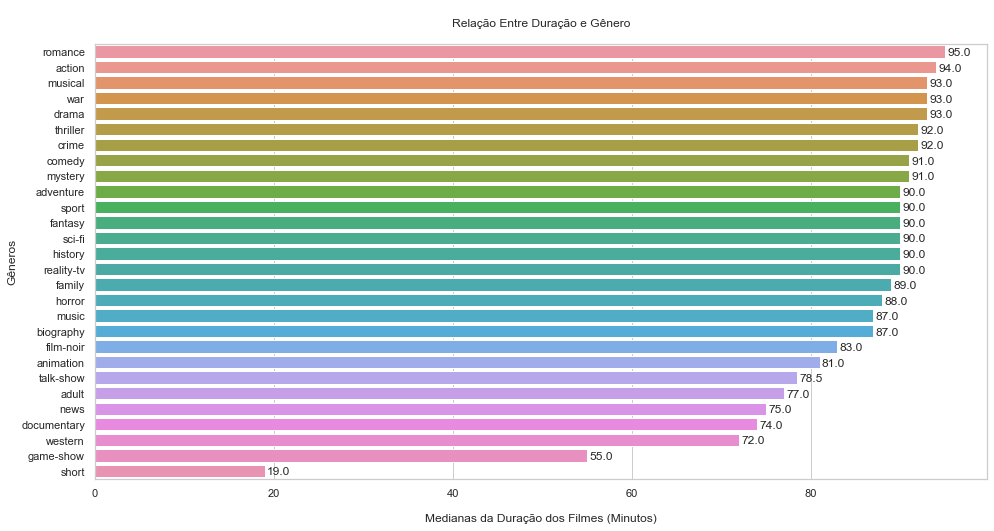

In [115]:
plt.figure(figsize = (16,8))
sns.barplot(y = df7['Gêneros'], x = df7['Medianas da Duração dos Filmes'], orient = "h")

for i in range(len(df7)):
    plt.text(df7['Medianas da Duração dos Filmes'][df7.index[i]] + 0.25,
    i + 0.25,
    str(df7['Medianas da Duração dos Filmes'][df7.index[i]]),
    fontsize=12)

plt.ylabel('Gêneros')             
plt.xlabel('\nMedianas da Duração dos Filmes (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# <font color='blue'>8- Qual o número de filmes produzidos por país?</font> 

In [120]:
verifica8 = pd.read_sql_query('''
                            SELECT region AS regiao, COUNT(*) n_filmes
                            FROM akas JOIN titles ON akas.title_id = titles.title_id
                            WHERE regiao != 'NULL' AND type ='movie'
                            GROUP BY regiao
                            ''',conn)
verifica8 = verifica8.sort_values(by=['n_filmes'], ascending=False).reset_index(drop=True)
verifica8

,regiao,n_filmes
0,US,303999
1,GB,156002
2,JP,89911
3,XWW,87631
4,FR,83158
...,...,...
229,WS,1
230,NC,1
231,MP,1
232,KI,1


In [121]:
lista = list(verifica8['regiao'])
lista

['US',
 'GB',
 'JP',
 'XWW',
 'FR',
 'IN',
 'CA',
 'DE',
 'IT',
 'ES',
 'BR',
 'GR',
 'PL',
 'RU',
 'HU',
 'FI',
 'PT',
 'SE',
 'MX',
 'AU',
 'DK',
 'TR',
 'AR',
 'XWG',
 'SUHH',
 'HK',
 'BG',
 'RO',
 'BE',
 'TW',
 'NO',
 'AT',
 'PH',
 'CN',
 'RS',
 'NL',
 'UA',
 'LT',
 'KR',
 'CZ',
 'HR',
 'XYU',
 'ID',
 'SI',
 'IL',
 'IR',
 'IE',
 'UY',
 'CL',
 'PE',
 'VN',
 'DDDE',
 'VE',
 'CSHH',
 'CH',
 'NZ',
 'CO',
 'EE',
 'SG',
 'AE',
 'SK',
 'EG',
 'LV',
 'ZA',
 'XEU',
 'PK',
 'MY',
 'TH',
 'NG',
 'BD',
 'UZ',
 'AL',
 'IS',
 'LK',
 'BA',
 'CU',
 'GE',
 'DO',
 'NP',
 'LB',
 'AZ',
 'DZ',
 'TN',
 'LU',
 'MA',
 'PA',
 'KZ',
 'PR',
 'EC',
 'BO',
 'AM',
 'BY',
 'CR',
 'JM',
 'MN',
 'XAS',
 'KP',
 'MK',
 'XKO',
 'KH',
 'IQ',
 'CM',
 'SA',
 'SY',
 'KE',
 'GH',
 'YUCS',
 'SN',
 'MD',
 'UG',
 'CY',
 'GT',
 'BF',
 'PY',
 'AF',
 'PS',
 'KG',
 'ME',
 'CG',
 'MT',
 'TT',
 'XSA',
 'SV',
 'LI',
 'KW',
 'HT',
 'XKV',
 'QA',
 'ET',
 'JO',
 'MZ',
 'TM',
 'MM',
 'MC',
 'TZ',
 'AO',
 'BJ',
 'GL',
 'BS',
 'ZW',
 'CI

In [122]:
nomes_paises = []
contador_filmes = []
for i in range(verifica8.shape[0]):
    try:
        lista_regiao = verifica8['regiao'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = lista_regiao).name)
# Haveria como pegar mais uns 4 paises atraves do codigo abaixo, para paises historicos. Mas o codigo acima é só
# pros paises listados atualmente na ISO, portanto, não só esses 4 históricos, mas uns 17 outros, que foram listados
# na primeira QUERY acima, não possuem correspondência com a lista atual da ISO
#       nomes_paises.append(pycountry.historic_countries.get(alpha_2 = lista_regiao).name) 
        contador_filmes.append(verifica8['n_filmes'].values[i])
    except:
        continue
len(nomes_paises)

213

In [123]:
df8 = pd.DataFrame()
df8['Países'] = nomes_paises
df8['Número de Filmes Produzidos'] = contador_filmes
df8 = df8.head(20)
df8

,Países,Número de Filmes Produzidos
0,United States,303999
1,United Kingdom,156002
2,Japan,89911
3,France,83158
4,India,77497
5,Canada,74094
6,Germany,68623
7,Italy,64546
8,Spain,64075
9,Brazil,63966


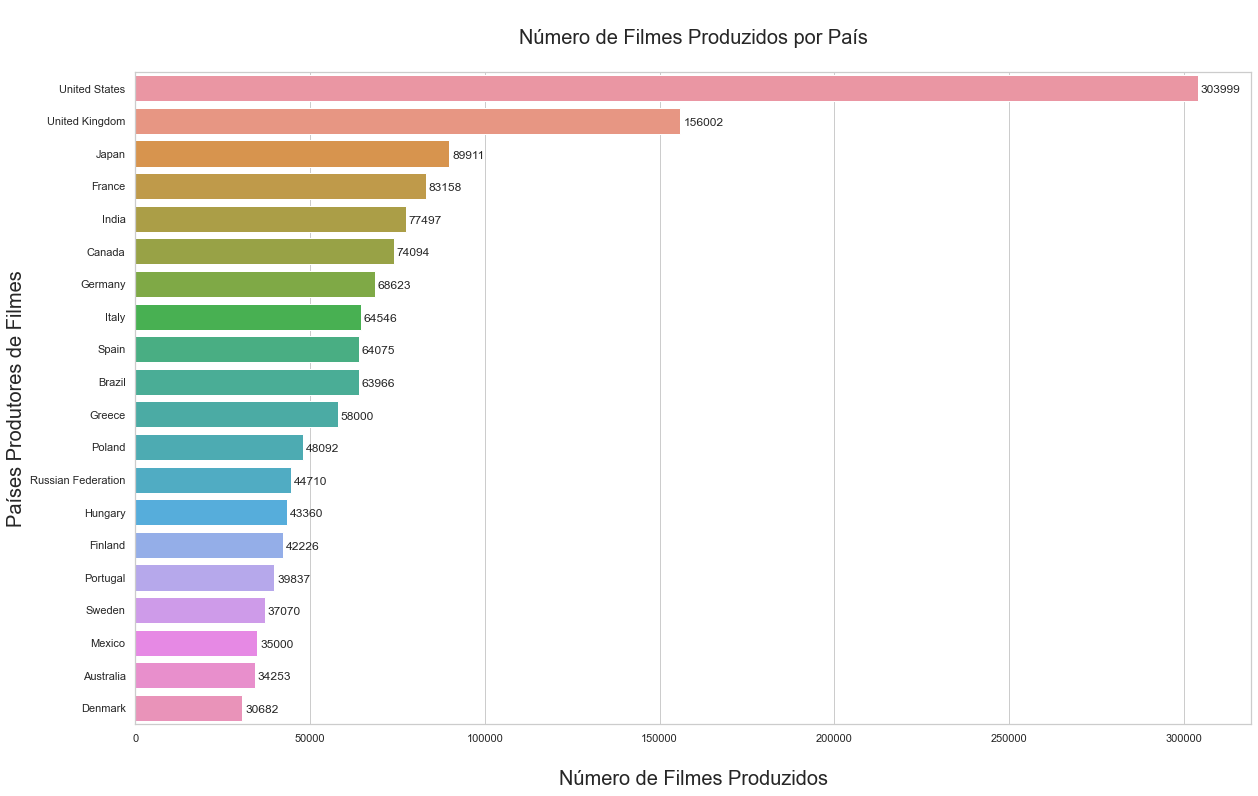

In [124]:
plt.figure(figsize = (20,12))
sns.barplot(y = df8['Países'], x = df8['Número de Filmes Produzidos'], orient = "h")

for i in range(len(df8)):
    plt.text(df8['Número de Filmes Produzidos'][i] + 800,
    i + 0.15,
    str(df8['Número de Filmes Produzidos'][i]),
    fontsize=12)

plt.ylabel('Países Produtores de Filmes', fontsize=20)             
plt.xlabel('\nNúmero de Filmes Produzidos', fontsize=20)
plt.title('\nNúmero de Filmes Produzidos por País\n', fontsize=20)
plt.show()

# <font color='blue'>9- Quais São os Top 10 Melhores Filmes?</font> 

In [126]:
verifica9 = pd.read_sql_query('''
                                SELECT
                                A.original_title AS Nomes_dos_Filmes, genres AS Gêneros, premiered AS Anos_de_Lançamento,
                                runtime_minutes AS Tempos_de_Duração,
                                B.rating AS Avaliações_dos_Filmes
                                FROM titles AS A LEFT JOIN ratings AS B ON A.title_id=B.title_id
                                WHERE A.type='movie' AND B.votes >= 25000 AND B.rating >= 1                            
                                ''',conn)
verifica9 = verifica9.sort_values(by=['Avaliações_dos_Filmes'], ascending=False).reset_index(drop=True)
verifica9 = verifica9.head(10)
verifica9

,Nomes_dos_Filmes,Gêneros,Anos_de_Lançamento,Tempos_de_Duração,Avaliações_dos_Filmes
0,Jai Bhim,"Crime,Drama",2021,164,9.4
1,Hababam Sinifi,"Comedy,Drama",1975,87,9.3
2,The Shawshank Redemption,Drama,1994,142,9.3
3,The Godfather,"Crime,Drama",1972,175,9.2
4,Soorarai Pottru,Drama,2020,153,9.1
5,Aynabaji,"Crime,Mystery,Thriller",2016,147,9.1
6,CM101MMXI Fundamentals,"Comedy,Documentary",2013,139,9.1
7,David Attenborough: A Life on Our Planet,"Biography,Documentary",2020,83,9.0
8,The Godfather: Part II,"Crime,Drama",1974,202,9.0
9,Spider-Man: No Way Home,"Action,Adventure,Fantasy",2021,148,9.0


# <font color='blue'>10- Quais São os Top 10 Piores Filmes?</font> 

In [128]:
verifica10 = pd.read_sql_query('''
                                SELECT
                                A.original_title AS Nomes_do_Filmes, genres AS Gêneros, premiered AS Anos_de_Lançamento,
                                runtime_minutes AS Tempos_de_Duração,
                                B.rating AS Avaliações_dos_Filmes
                                FROM titles AS A LEFT JOIN ratings AS B ON A.title_id=B.title_id
                                WHERE A.type='movie' AND B.votes >= 25000 AND B.rating >= 1                            
                                ''',conn)
verifica10 = verifica10.sort_values(by=['Avaliações_dos_Filmes'], ascending=True).reset_index(drop=True)
verifica10 = verifica10.head(10)
verifica10

,Nomes_do_Filmes,Gêneros,Anos_de_Lançamento,Tempos_de_Duração,Avaliações_dos_Filmes
0,Cumali Ceber: Allah Seni Alsin,Comedy,2017,100,1.0
1,Sadak 2,"Action,Drama",2020,133,1.1
2,Smolensk,"Drama,Thriller",2016,120,1.2
3,Reis,"Biography,Drama",2017,108,1.4
4,Elk*rtuk,"Crime,Drama,History",2021,125,1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",2011,105,1.6
6,Manos: The Hands of Fate,Horror,1966,70,1.8
7,Radhe,"Action,Crime,Thriller",2021,135,1.9
8,The Hottie & the Nottie,"Comedy,Romance",2008,91,1.9
9,Disaster Movie,"Comedy,Sci-Fi",2008,87,1.9
